In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import ICP
import shelve
import os

In [26]:
from skimage.util import img_as_float
from skimage.color import rgb2gray

In [27]:
from scipy.io.matlab import loadmat, savemat
import os
import pandas
import scipy.interpolate as si
import scipy.ndimage as ndi

This notebook reads in images extracted from a video, along with the XY locations of changes in each frame. 
The changes are clustered into connected components and an effort was made to provide the track of one connected component from the video. 

You will need to obtain the frame images and the XY data in order to run this notebook.

In [28]:
centroids_csv = '../data/centers.tdt'  #This is a path to a file that should be in the repo. 

In [29]:
cent = pandas.read_csv(centroids_csv, sep=' ', header=None, 
                       names=['x','y'], usecols=[1,2], index_col=False)

In [30]:
cent

x           y
0    105.275862  224.655172
1    102.268657  226.537313
2    145.000000   75.000000
3    100.294118  227.205882
4    103.454545  225.681818
5    102.105263  227.157895
6    103.542857  225.914286
7    103.733333  225.533333
8    104.562500  225.812500
9    104.393939  225.636364
10   105.513514  225.135135
11   105.187500  224.875000
12   106.300000  224.666667
13   106.186047  224.418605
14   107.433333  223.666667
15   107.282051  223.410256
16   108.461538  223.461538
17   108.066667  223.033333
18   108.920000  222.600000
19   109.000000  223.052632
20   110.225806  222.419355
21   114.000000  222.500000
22   111.142857  222.000000
23   112.103448  221.827586
24   112.434783  222.000000
25   112.600000  221.900000
26   113.484848  221.484848
27   114.333333  221.333333
28   114.444444  220.666667
29   116.260870  220.434783
..          ...         ...
179  196.384615  186.871795
180  196.555556  187.444444
181  198.142857  186.750000
182  198.296296  186.629630
183  198.000000  186.666667
184  197.800000  187.466667
185  199.000000  187.000000
186  198.500000  187.050000
187  199.000000  187.538462
188  199.062500  186.937500
189  199.062500  187.187500
190  199.500000  187.333333
191  199.400000  186.866667
192  200.222222  186.666667
193  200.500000  187.000000
194  200.666667  187.166667
195  201.000000  187.000000
196  201.000000  186.500000
197  104.500000  199.500000
198  104.500000  199.500000
199  104.500000  199.500000
200  104.500000  199.500000
201  200.500000  169.000000
202  104.500000  199.500000
203  104.500000  199.500000
204  104.500000  199.500000
205  104.500000  199.500000
206  104.500000  199.500000
207  104.500000  199.500000
208  104.500000  199.500000

[209 rows x 2 columns]

In [68]:
cx = array(cent['x'])
cy = array(cent['y'])

In [75]:
figsize(15,10)
imshow(imread('../data/frame140.tif'))
plot(cy, cx, c='r');
xlim(0,400)
ylim(210,0)

(210, 0)

We seem to have BOTH duplicated points and also mis-identified targets (we switch to a completely differtent part of the image every now and then).  

Also I am not sure but we seem to be osculating back and forth a little bit..

In [78]:
duplicate_threshold = .1
miss_threshold = 20
speeds = hypot( diff(cx), diff(cy))
speeds = append(speeds, speeds[-1])
duplicates = speeds < duplicate_threshold
misses = speeds > miss_threshold
speeds.shape
good =~misses & ~duplicates

In [86]:
figsize(15,10)
imshow(imread('../data/frame140.tif'))
plot(cy[good], cx[good], label='"good"')
scatter(cy[misses], cx[misses], c='r', s=50, label='outliers')
scatter(cy[duplicates], cx[duplicates], c='y', label='duplicates')
legend()
xlim(150,280)
ylim(220,90);

(-5, 5)

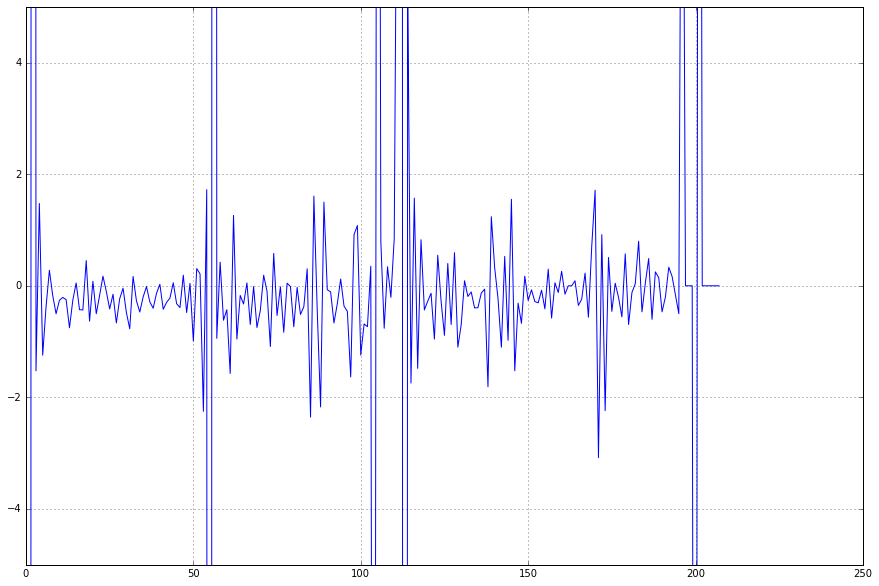

In [91]:
plot(diff(cy))
grid()
ylim(-5, 5)

The 'y' component of speed for this carr should ALWAYS be positive as it is moving down the image at a constant speed. I think Bharatt is randomly detecting eighter the leading or trailing edge of the car...

In [101]:
cx_trimmed, cy_trimmed= cx[:-40], cy[:-40]
dx, dy = diff(cx_trimmed), diff(cy_trimmed)
d = hypot(dx, dy)
good = (d < 5) & (d > 1)
good = np.append(good, good[-1])
print good.shape
print cx_trimmed.shape

(169L,)
(169L,)


I want to move the "bad" points into a position that is as smooth as possible, and I also want the "good" points to pretty much stay where they are but get a litttle bit smoother. 

I am doing a VERY HACKY thing here that is probably not corrrect but that appears to produce useable results FOR NOW. We should not publish this part of the process until we look up a better way to handle this...
 
 * Weighted least squares approcimation with smoothing euations, and weights based off of out "good" or "bad" determination above may bve reasonable.
 * Kalman filtering?

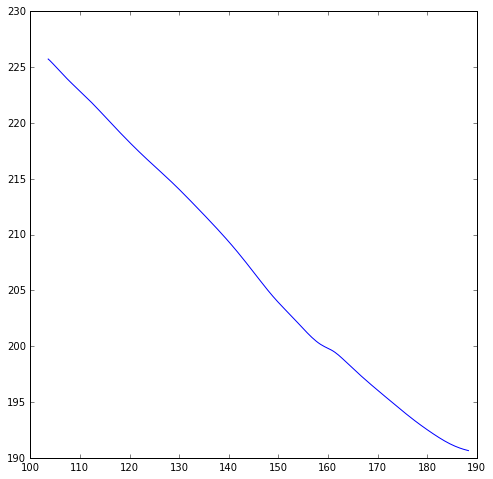

In [103]:
scx = cx_trimmed.copy()
scy = cy_trimmed.copy()
for k in range(1, 10):
    scx = ndi.gaussian_filter(scx, sigma=5)
    scy = ndi.gaussian_filter(scy, sigma=5)
    scx[good] = cx_trimmed[good]
    scy[good] = cy_trimmed[good]

scx = ndi.gaussian_filter(scx, sigma=5)
scy = ndi.gaussian_filter(scy, sigma=5)

figsize(8,8); plot(scx, scy);

As a sanity check, let's plot the apparent direction of motion for these changes. 

This is probably also the direction that the care is facing (we are trackign a car)

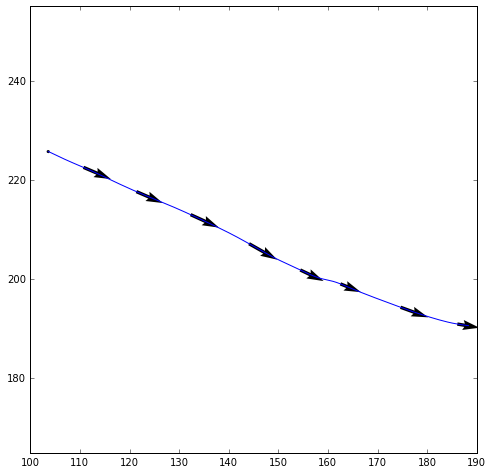

In [109]:
dx = (diff(scx) - diff(scx[::-1])[::-1])/2
dy = (diff(scy) - diff(scy[::-1])[::-1])/2
dx = append(dx, dx[-1])
dy = append(dy, dy[-1])
stp=20
plot(scx, scy)
quiver(scx[::stp], scy[::stp], dx[::stp], dy[::stp], )
axis('equal');

Note that the first speed is very low because we are just smoothing instead of something more intelligent

In [115]:
#NOTE: These variables appear to duplicate ones declared earlier th
indir = '../data'
frames = [os.path.join(indir, f) for f in os.listdir(indir) if f.endswith('.tif')]

# Recall we trimmed off some frames from the end...
frames = frames[:len(scx)]
print len(frames)

 169


In [116]:
angles = np.arctan2(dy, dx)  # These will be in radians measured CCW from horizontal (+x)
print len(angles)

169


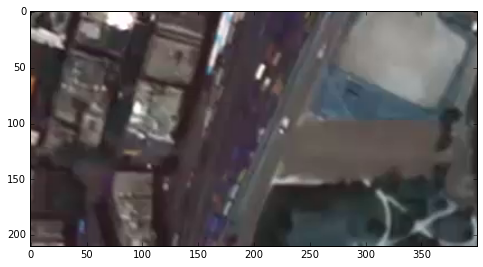

In [117]:
imshow(imread(frames[0]))

In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

168


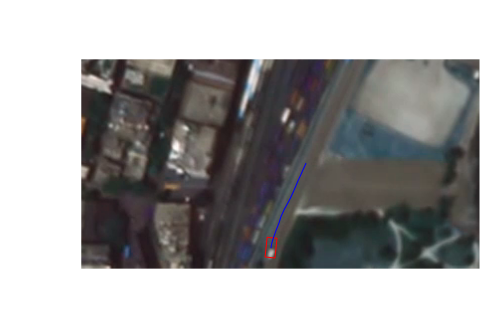

In [119]:
# Render out a figure for every frame, 
# that shows a rectangle around the car and that shows 
# the car's path superimposed on the frame. 

print 0,

if not os.path.isdir('outdir/f1'):
     os.makedirs('outdir/f1')
for frame in range(len(frames)):
    img = imread(frames[frame])
    cla()
    imshow(img)
    w, h=20, 10
    
    ax = array([cos(angles[frame]), sin(angles[frame])])
    ay = array([-sin(angles[frame]), cos(angles[frame])])
    cc = array([scx[frame], scy[frame]])
    ll = cc - 0.5*w*ax - 0.5*h*ay
    
    rect = patches.Rectangle((ll[1], ll[0]),h,w, angle=degrees(-angles[frame]), fill=False,
                    color='r')
    gca().add_patch(rect)
    axis('off')
    plot(scy, scx)
    plt.savefig('outdir/f1/frame{:03}.tif'.format(frame))
    print '\r', frame,

And if you have installed ffmpeg and it is  on the path....

In [138]:
!ffmpeg  -i outdir/f1/frame%03d.tif outdir/f1.webm -y

ffmpeg version N-50911-g9efcfbe Copyright (c) 2000-2013 the FFmpeg developers
  built on Mar 13 2013 21:26:48 with gcc 4.7.2 (GCC)
  configuration: --enable-gpl --enable-version3 --disable-w32threads --enable-avisynth --enable-bzlib --enable-fontconfig --enable-frei0r --enable-gnutls --enable-libass --enable-libbluray --enable-libcaca --enable-libfreetype --enable-libgsm --enable-libilbc --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvo-aacenc --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libxavs --enable-libxvid --enable-zlib
  libavutil      52. 19.100 / 52. 19.100
  libavcodec     55.  0.100 / 55.  0.100
  libavformat    55.  0.100 / 55.  0.100
  libavdevice    54.  4.100 / 54.  4.100
  libavfilter     3. 45.103 /  3. 45.103
  libswscale      2.  2.100 / 

In [139]:
def video(fname, mimetype):
    from IPython.display import HTML
    video_encoded = open(fname, "rb").read().encode("base64")
    video_tag = '<video controls alt="test" src="data:video/{0};base64,{1}">'.format(mimetype, video_encoded)
    return HTML(data=video_tag)

In [140]:
video('outdir/f1.webm', 'webm')

Now I will show the input video alongside the extracted, scales, and rotated region the is the car.

In [126]:
from skimage.transform import warp, AffineTransform
from affine import Affine
from skimage.util import img_as_float

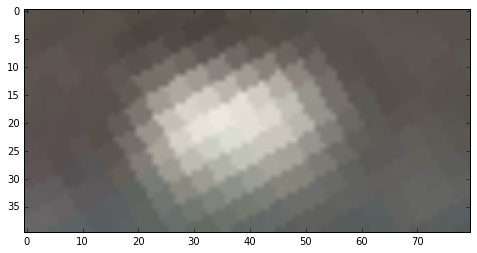

In [128]:
# lw, lh   are global variables that indicate how big the car is in the video. They are listed
# here as pixels, but really I should be sticking with physiical units and have a PPM (pixels per meter)
# setting....

lw, lh = 20,10


def extract_car(img, x, y, angle, w, h):
    t = Affine.translation(x, y)
    t *= Affine.rotation(degrees(angle)-90)
    t *= Affine.scale(float(lw)/w)
    t *= Affine.translation(-w/2., -h/2.)
    mtx = np.array(t).reshape(3,3)
    result = warp(img, AffineTransform(mtx), output_shape=(h, w, 3), order=0)
    return result

frame = 80
img = (imread(frames[frame]))
car = extract_car(img, scy[frame], scx[frame], angles[frame], 80, 40)
imshow(car);

In [135]:
if not os.path.isdir('outdir/f2'):
     os.makedirs('outdir/f2')

print ''        
for frame in range(len(frames)):
    img = imread(frames[frame])
    w, h=20, 10
    
    clf()
    ax = array([cos(angles[frame]), sin(angles[frame])])
    ay = array([-sin(angles[frame]), cos(angles[frame])])
    cc = array([scx[frame], scy[frame]])
    ll = cc - 0.5*w*ax - 0.5*h*ay
    
    subplot(2, 2, 1)
    imshow(img)
    rect = patches.Rectangle((ll[1], ll[0]),h,w, angle=degrees(-angles[frame]), fill=False,
                    color='r')
    gca().add_patch(rect)
    axis('off')
    plot( scy, scx)
    
    subplot(2, 2, 2)
    car = extract_car(img, scy[frame], scx[frame], angles[frame], 80, 40)
    imshow(car)
    
    
    subplot(2, 2, 3)
    fcx = scx[frame]
    fcy = scy[frame]
    imshow(img[fcx-40:fcx+40, fcy-40:fcy+40])
    axis('off')
    title('{}-{}, {}-{}'.format(fcx-40, fcx+40, fcy-40, fcy+40))
    
    plt.savefig('outdir/f2/frame{:03}.tif'.format(frame))
    #plt.show()
    print '\r', frame,


168


C:\Anaconda\envs\dfc\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [136]:
!ffmpeg  -i outdir/f2/frame%03d.tif outdir/f2.webm -y

ffmpeg version N-50911-g9efcfbe Copyright (c) 2000-2013 the FFmpeg developers
  built on Mar 13 2013 21:26:48 with gcc 4.7.2 (GCC)
  configuration: --enable-gpl --enable-version3 --disable-w32threads --enable-avisynth --enable-bzlib --enable-fontconfig --enable-frei0r --enable-gnutls --enable-libass --enable-libbluray --enable-libcaca --enable-libfreetype --enable-libgsm --enable-libilbc --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvo-aacenc --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libxavs --enable-libxvid --enable-zlib
  libavutil      52. 19.100 / 52. 19.100
  libavcodec     55.  0.100 / 55.  0.100
  libavformat    55.  0.100 / 55.  0.100
  libavdevice    54.  4.100 / 54.  4.100
  libavfilter     3. 45.103 /  3. 45.103
  libswscale      2.  2.100 / 

In [137]:
video( r'outdir\f2.webm', "webm")

These images do not appear to be registered well enough

How can we improve the registration?